# K-NN using matrices : efficient computation of similarities / distance for each pairs (train vector, test vector)

** COPY THIS NOTEBOOK AND RENAME IT ADDING YOUR NAME **

Suppose we have n=4 training examples, and t=2 test examples, 
 the objects being represented with vectors with size d=3.

- the training vectors are in a (n,d) ndarray
- the test vectors are in a (t,d) ndarray .

In [20]:
# Importing necessary libraries:
from scipy import stats as st
import matplotlib.pyplot as plt
from math import *
import numpy as np
from time import time

In [21]:
# Toy corpus:
X_train = np.array( [[0, 1, 1], [1, 2, 0], [-1, 0,2], [1,0,-1]])
X_test = np.array( [[0,2,2], [-1,-2,0] ] )
print(X_train)
print(X_test)
print(X_train.shape[0])
print(X_test.shape[0])

[[ 0  1  1]
 [ 1  2  0]
 [-1  0  2]
 [ 1  0 -1]]
[[ 0  2  2]
 [-1 -2  0]]
4
2


## Cosine

In [22]:
# Using for lopps: cosine between each pair (row of X_train, row of X_test)
def cosine(x,y):
    return np.dot(x,y) / (np.linalg.norm(x) * np.linalg.norm(y))
def cosine_matrix(X_train, X_test):
    cosines = np.zeros((X_train.shape[0], X_test.shape[0]))
    for i in range(X_train.shape[0]):
        for j in range(X_test.shape[0]):
            cosines[i,j] = cosine(X_train[i,:], X_test[j,:])
    return cosines

print(cosine_matrix(X_train, X_test))

# Using numpy broadcasting:
def cosine_mtrx(X_train, X_test):
    X_train_norm = X_train / np.linalg.norm(X_train, axis=1)[:, np.newaxis]
    X_test_norm = X_test / np.linalg.norm(X_test, axis=1)[:, np.newaxis]
    return np.dot(X_train_norm, X_test_norm.T)

def cosine_mtrx1(X_train, X_test):
    numerator = X_train @ X_test.T
    denominator = np.linalg.norm(X_train, axis=1)[:, np.newaxis] * np.linalg.norm(X_test, axis=1)
    return numerator / denominator

print(cosine_mtrx(X_train, X_test))
print(cosine_mtrx1(X_train, X_test))


[[ 1.         -0.63245553]
 [ 0.63245553 -1.        ]
 [ 0.63245553  0.2       ]
 [-0.5        -0.31622777]]
[[ 1.         -0.63245553]
 [ 0.63245553 -1.        ]
 [ 0.63245553  0.2       ]
 [-0.5        -0.31622777]]
[[ 1.         -0.63245553]
 [ 0.63245553 -1.        ]
 [ 0.63245553  0.2       ]
 [-0.5        -0.31622777]]


## Euclidian distances

In [23]:
# NB: many solutions are possible
# Using for loops:
def distance_to_vector(x,y):
    return np.sqrt(np.linalg.norm(x)**2 + np.linalg.norm(y)**2 - 2*np.dot(x,y))
def distance_matrix(X_train, X_test):
    distances = np.zeros((X_train.shape[0], X_test.shape[0]))
    for i in range(X_train.shape[0]):
        for j in range(X_test.shape[0]):
            distances[i,j] = distance_to_vector(X_train[i,:], X_test[j,:])
    return distances
# you can use the formulation
# dist(a,b) = square root of (a^2 + b^2 -2 a.b)
#print(distance_matrix(X_train, X_test))

# Using numpy broadcasting:
def distance_mtrx(X_train, X_test):
    distance = np.sqrt((X_train**2).sum(axis=1)[:, np.newaxis] 
                       + (X_test**2).sum(axis=1) - 2 * X_train.dot(X_test.T))
    return distance

print(distance_mtrx(X_train, X_test))



[[1.41421356 3.31662479]
 [2.23606798 4.47213595]
 [2.23606798 2.82842712]
 [3.74165739 3.        ]]


In [24]:
def read_examples(file_train, file_test):
    # Open the train and test files
    # I decided to read both train and test to avoid creating an Index class
    stream_train = open(file_train)
    stream_test = open(file_test)
    
    # Initialize empty lists to store examples and gold classes
    # I understood the use of Example class last lab, so I wanted to try not using it this time.
    examples_train = []
    examples_test = []
    gold_train = []
    gold_test = []
    example_train_data = None
    example_test_data = None  
     
    # Initialize empty dictionaries to store the word to index and class to index mappings
    w2i = {} # Word to index dictionary
    word_id = 0 
    c2i = {} # Class to index dictionary
    class_id = 0


    # Read the train file using read_examples() from last lab.
    while 1:
        line1 = stream_train.readline()
        if not line1:
            break
        line1 = line1[0:-1]
        if line1.startswith("EXAMPLE_NB"):
            if example_train_data:
                examples_train.append(example_train_data)
            cols = line1.split('\t')
            gold_class = cols[3]
            # If the class is not in the c2i dictionary, add it
            if gold_class not in c2i:
                c2i[gold_class] = class_id
                class_id += 1
            # I did not use i2c since I thought that I can iterate the key.
            gold_train.append(c2i[gold_class])
            example_train_data = []
        elif line1 and example_train_data is not None:
            (featname, val) = line1.split('\t')
            # If the feature is not in the w2i dictionary, add it
            if featname not in w2i:
                w2i[featname] = word_id
                word_id += 1
            # Same reasoning for not using i2w
            example_train_data.append((w2i[featname], float(val)))
    
    if example_train_data:
        examples_train.append(example_train_data)
    # Convert the gold classes list to numpy arrays
    gold_train = np.array(gold_train)    
    
    # Read the test file:
    while 1:
        line = stream_test.readline()
        if not line:
            break
        line = line[0:-1]
        if line.startswith("EXAMPLE_NB"):
            if example_test_data:
                examples_test.append(example_test_data)
            cols = line.split('\t')
            gold_class = cols[3]
            # If the class is not in the c2i dictionary, add it
            if gold_class not in c2i:
                c2i[gold_class] = class_id
                class_id += 1
            gold_test.append(c2i[gold_class])
            example_test_data = []
        elif line and example_test_data is not None:
            (featname, val) = line.split('\t')
            # Since we don't care about words that are not in the train set,
            # we don't add them to the w2i dictionary
            if featname not in w2i:
                continue
            example_test_data.append((w2i[featname], float(val)))
    
    if example_test_data:
        examples_test.append(example_test_data)
    # Turn the gold classes list to numpy arrays
    gold_test = np.array(gold_test)
    
    # Build the feature matrix for train and test examples:
    # I use len(w2i) here because I did not add the words
    # that are not in the train set into the vocabulary.
    train_matrix = np.zeros((len(examples_train), len(w2i)))
    for i, example in enumerate(examples_train):
        for j, value in example:
            train_matrix[i, j] = value    
    test_matrix = np.zeros((len(examples_test), len(w2i)))
    for i, example in enumerate(examples_test):
        for j, value in example:
            test_matrix[i, j] = value  
    # After reading examples, we obtain the train and test feature matrices, and the gold classes
    return train_matrix, test_matrix, gold_train, gold_test

In [25]:
# Read the examples from train and test files:
X_train, X_test, y_train, y_test = read_examples("reuters.train.examples", "reuters.test.examples")


In [26]:
# Checking the results of the functions:
print("The shape of the train set is: ", X_train.shape)
print("The shape of the test set is: ", X_test.shape)
print("Accordingly, the shape of y_train is: ", y_train.shape)
print("The shape of the y_test is:", y_test.shape)
# Testing the cosine and distance functions:
print("The cosine and distance matrix is returning the correct shape: ")
print(cosine_mtrx(X_train, X_test).shape)
print(distance_mtrx(X_train, X_test).shape) 

The shape of the train set is:  (8806, 12657)
The shape of the test set is:  (2347, 12657)
Accordingly, the shape of y_train is:  (8806,)
The shape of the y_test is: (2347,)
The cosine and distance matrix is returning the correct shape: 
(8806, 2347)
(8806, 2347)


In [27]:
# Because of calculation errors, we sometimes end up with negative distances.
# We take here a minimal value of distance, positive (to be able to take the root) and not null (to be able to take the inverse).
MINDIST =  1e-18
# KNN class:
class KNN:
    """
    K-NN for document classification (multiclass classification)

    members = 

    K = the number of neighbors to consider for taking the majority vote

    examples = list of Example instances

    """
    def __init__(self, X_train, y_train, K=1, weight_neighbors=None, use_cosine=False, trace=False):
        # examples = list of Example instances
        self.X_train = X_train
        self.y_train = y_train
        # the number of neighbors to consider for taking the majority vote
        self.K = K
        # boolean : whether to weight neighbors (by inverse of distance) or not
        self.weight_neighbors = weight_neighbors
        # boolean : whether to use cosine similarity instead of euclidian distance
        self.use_cosine = use_cosine
        # whether to print some traces or not
        self.trace = trace
        

    def predict(self, X_test):
        """
        K-NN prediction for this ovector,
        for k values from 1 to self.K

        Returns: a K-long list of predicted classes,
        the class at position i is the K-NN prediction when using K=i
        """

        # Functions to compute the distance matrix:
        def distance_mtrx(X_train, X_test):
            distance = np.sqrt((X_train**2).sum(axis=1)[:, np.newaxis] 
                       + (X_test**2).sum(axis=1) - 2 * X_train.dot(X_test.T))
            return distance + MINDIST
        # Here I calculate -cosine so that I can sort increasing distances
        def cosine_mtrx(X_train, X_test):
            X_train_norm = X_train / np.linalg.norm(X_train, axis=1)[:, np.newaxis]
            X_test_norm = X_test / np.linalg.norm(X_test, axis=1)[:, np.newaxis]
            cosine = np.dot(X_train_norm, X_test_norm.T)
            return -cosine
        
        # Compute the distance matrix, depends on the hyperparameters:
        if self.use_cosine: # I calculated -cosine so that I can sort increasing distances
            distances = cosine_mtrx(self.X_train, X_test)
        else:
            distances = distance_mtrx(self.X_train, X_test)

        if self.weight_neighbors and self.use_cosine:
            distances = (distances+1)
        elif self.weight_neighbors and not self.use_cosine:
            # Inverse the distances. I had to include a reverse to account for reverse sorting.
            distances = -1/distances

        # Sort the distances and index in increasing order for each column,
        # cosine was calculated as -cosine: 
        sorted_index = np.argsort(distances, axis=0)
        sorted_y_train = self.y_train[sorted_index]        
        # Compute the K nearest neighbors:
        pred_classes = np.zeros((self.K, X_test.shape[0]))
        for j in range(1, self.K+1):
            y_train_neighbors = sorted_y_train[:j]
            # I am using the mode function from scipy.stats to get the most frequent class:
            # Going by row, so axis=0 to get the most frequent class for each example.
            (values, counts) = st.mode(y_train_neighbors, axis=0, keepdims=False)
            pred_classes[j-1] = values
        return pred_classes # The result is a matrix of size K x len(y_test)

    def score(self, X_test, y_test):
        """ Runs the K-NN classifier on a list of Example instances
        and evaluates the obtained accuracy

        Returns: a K-long list of accuracies,
        the accuracy at position i is the one obtained when using K=i
        """
        # Compute the predicted classes for each example in the test set:
        pred_classes = self.predict(X_test)
        accuracies = []
        for i in range(1, self.K + 1):
            # Compute the row accuracy for each row of y_pred:
            y_pred = pred_classes[i-1:i, :]
            row_accuracies = np.mean(y_pred == y_test.reshape(1, -1), axis=1)
            # Take the average of the row accuracies to get the overall accuracy:
            accuracy = np.mean(row_accuracies)
            accuracies.append(accuracy)
        return accuracies

Done in 33.196s


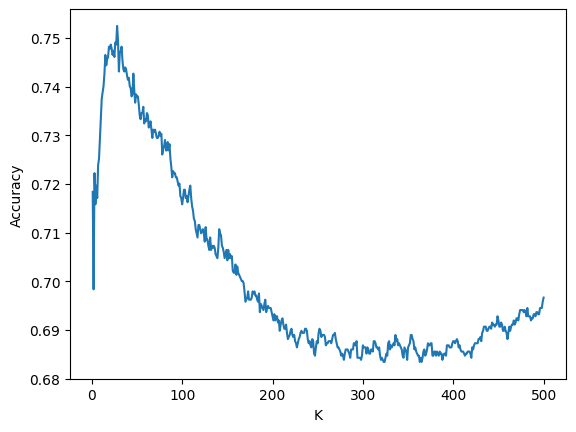

The best value of K is 28


In [28]:
# Testing the KNN class with Euclidian distance and no weighting:
myclassifier = KNN(X_train, y_train, K=500, use_cosine=False, weight_neighbors=False)
t0 = time()
accuracies = myclassifier.score(X_test, y_test)
print("Done in %0.3fs" % (time() - t0))
# Plotting the accuracies:
plt.plot(range(1, len(accuracies)+1), accuracies)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()
print("The best value of K is %d" % (accuracies.index(max(accuracies))+1))

Done in 34.775s


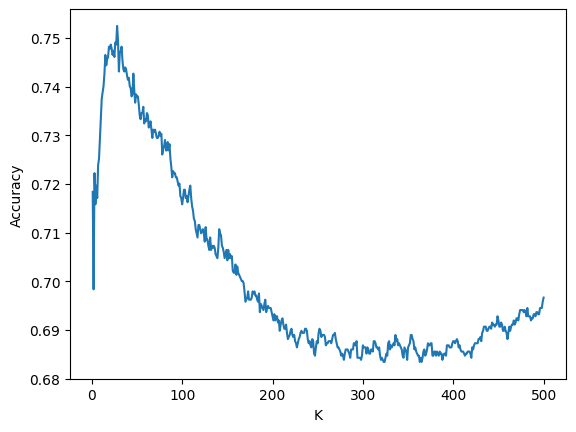

The best value of K is 28


In [29]:
# Testing the KNN class with weighted Euclidian distance:
myclassifier = KNN(X_train, y_train, K=500, use_cosine=False, weight_neighbors=True)
t0 = time()
accuracies = myclassifier.score(X_test, y_test)
print("Done in %0.3fs" % (time() - t0))
# Plotting the accuracies:
plt.plot(range(1, len(accuracies)+1), accuracies)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()
print("The best value of K is %d" % (accuracies.index(max(accuracies))+1))

Done in 32.971s


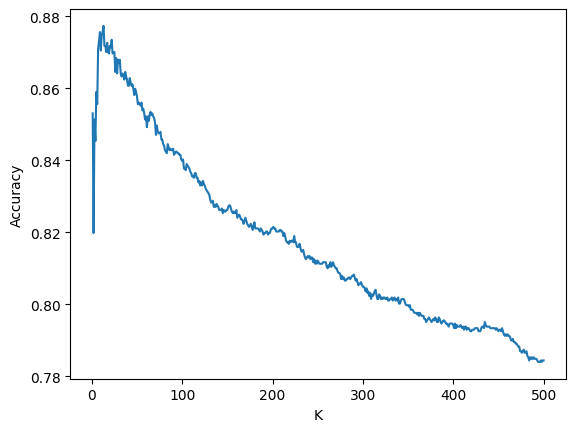

The best value of K is 13


In [30]:
# Testing the KNN class with cosine similarity and no weighting:
myclassifier = KNN(X_train, y_train, K=500, use_cosine=True, weight_neighbors=False)
t0 = time()
accuracies = myclassifier.score(X_test, y_test)
print("Done in %0.3fs" % (time() - t0))
# Plotting the accuracies:
plt.plot(range(1, len(accuracies)+1), accuracies)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()
print("The best value of K is %d" % (accuracies.index(max(accuracies))+1))

Done in 34.233s


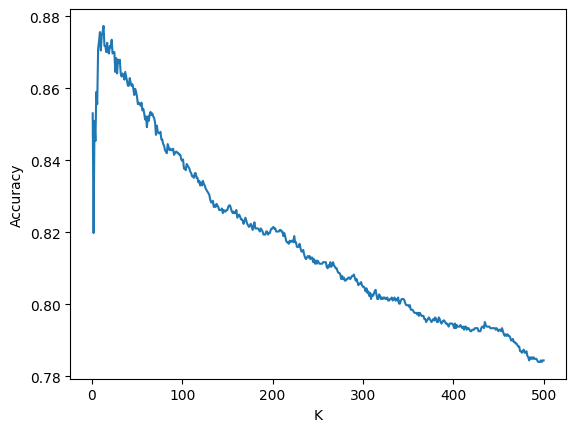

The best value of K is 13


In [31]:
# Testing the KNN class with cosine similarity and weighting:
myclassifier = KNN(X_train, y_train, K=500, use_cosine=True, weight_neighbors=True)
t0 = time()
accuracies = myclassifier.score(X_test, y_test)
print("Done in %0.3fs" % (time() - t0))
# Plotting the accuracies:
plt.plot(range(1, len(accuracies)+1), accuracies)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()
print("The best value of K is %d" % (accuracies.index(max(accuracies))+1))

In [32]:
# Test the KNN on the medium dataset:
# Read the examples from train and test files:
X_train, X_test, y_train, y_test = read_examples("medium.train.examples", "medium.dev.examples")

Done in 2.597s


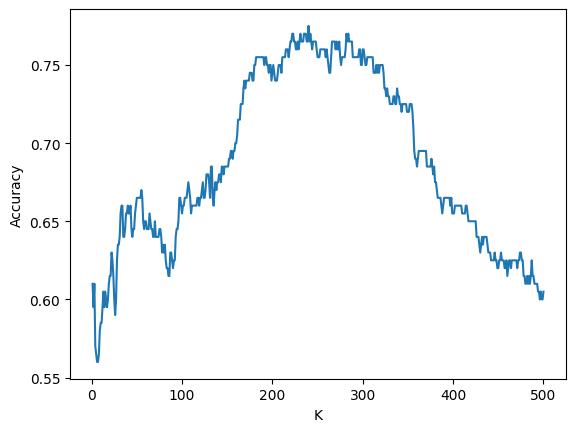

The best value of K is 240


In [33]:
# Testing the KNN class with Euclidian distance and no weighting:
myclassifier = KNN(X_train, y_train, K=500, use_cosine=False, weight_neighbors=False)
t0 = time()
accuracies = myclassifier.score(X_test, y_test)
print("Done in %0.3fs" % (time() - t0))
# Plotting the accuracies:
plt.plot(range(1, len(accuracies)+1), accuracies)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()
print("The best value of K is %d" % (accuracies.index(max(accuracies))+1))

Done in 2.603s


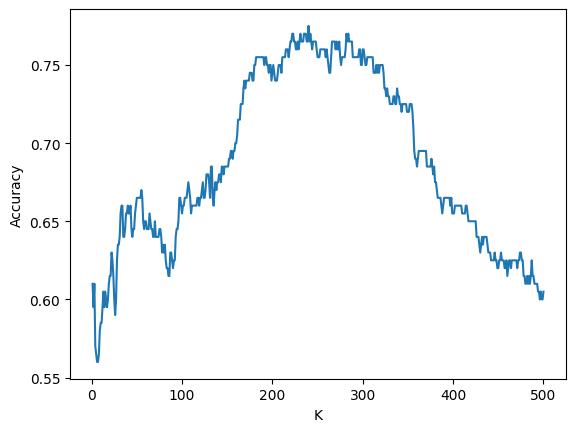

The best value of K is 240


In [34]:
# Testing the KNN class with weighted Euclidian distance:
myclassifier = KNN(X_train, y_train, K=500, use_cosine=False, weight_neighbors=True)
t0 = time()
accuracies = myclassifier.score(X_test, y_test)
print("Done in %0.3fs" % (time() - t0))
# Plotting the accuracies:
plt.plot(range(1, len(accuracies)+1), accuracies)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()
print("The best value of K is %d" % (accuracies.index(max(accuracies))+1))

Done in 2.537s


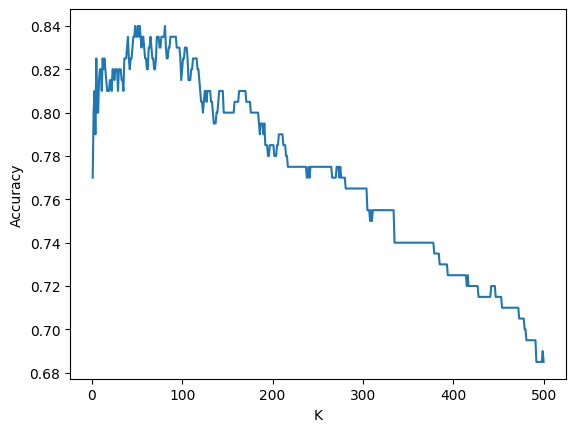

The best value of K is 48


In [35]:
# Testing the KNN class with cosine similarity and no weighting:
myclassifier = KNN(X_train, y_train, K=500, use_cosine=True, weight_neighbors=False)
t0 = time()
accuracies = myclassifier.score(X_test, y_test)
print("Done in %0.3fs" % (time() - t0))
# Plotting the accuracies:
plt.plot(range(1, len(accuracies)+1), accuracies)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()
print("The best value of K is %d" % (accuracies.index(max(accuracies))+1))

Done in 2.539s


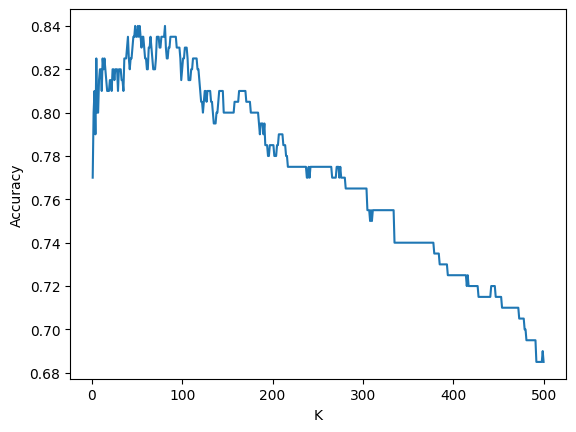

The best value of K is 48


In [36]:
# Testing the KNN class with cosine similarity and weighting:
myclassifier = KNN(X_train, y_train, K=500, use_cosine=True, weight_neighbors=True)
t0 = time()
accuracies = myclassifier.score(X_test, y_test)
print("Done in %0.3fs" % (time() - t0))
# Plotting the accuracies:
plt.plot(range(1, len(accuracies)+1), accuracies)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()
print("The best value of K is %d" % (accuracies.index(max(accuracies))+1))